In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json
from scipy import signal, interpolate

## Question 1

### a.)

In [2]:
directory = 'LOSC_Event_tutorial/'

def read_template(filename):
    dataFile=h5py.File(directory+filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    
    return th,tl

def read_file(filename):
    dataFile=h5py.File(directory+filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)
    
    dataFile.close()
    
    return strain,dt,utc

In [3]:
with open(directory+'BBH_events_v3.json') as file:
    json_dat = json.load(file)
list_events = list(json_dat.keys())
H_event, L_event, H_template, L_template = [],[],[],[]

for i in range(len(list_events)):
    event = list_events[i]
    H = json_dat[event]['fn_H1']
    L = json_dat[event]['fn_L1']
    temp = json_dat[event]['fn_template']
    H_event.append(read_file(H))
    L_event.append(read_file(L))
    H_temp, L_temp = read_template(temp)
    H_template.append(H_temp)
    L_template.append(L_temp)
file.close()

In [4]:
def Smooth(x):
    fft = np.fft.fft(x)
    n = np.arange(len(x))
    fun = np.exp(-0.5 * (n)**2)
    funfft = np.fft.fft(fun)
    return np.abs(np.fft.ifft(fft * funfft))

In [5]:
def Noise():
    noise = []
    for i in range(len(L_event)):
        H_strain, H_dt = np.array(H_event, dtype = object).T[:2,i]
        L_strain, L_dt = np.array(L_event, dtype = object).T[:2,i]
        H_freq, H_pxx = signal.welch(H_strain, 1/H_dt, nperseg = 1/H_dt, window = 'tukey')
        L_freq, L_pxx = signal.welch(L_strain, 1/L_dt, nperseg = 1/L_dt, window = 'tukey')
        H_noise = Smooth(H_pxx)
        L_noise = Smooth(L_pxx)
        plt.loglog(H_noise, label = 'H')
        plt.loglog(L_noise, label = 'L')
        plt.legend()
        plt.show()
        noise.append({"H_noise": H_noise, "L_noise": L_noise,
                      "H_freq": H_freq, "L_freq": L_freq, 
                      "H_strain": H_strain, "L_strain": L_strain,
                      "H_dt": H_dt, "L_dt": L_dt,
                      "H_template": H_template[i], "L_template": L_template[i]})
       
    return noise

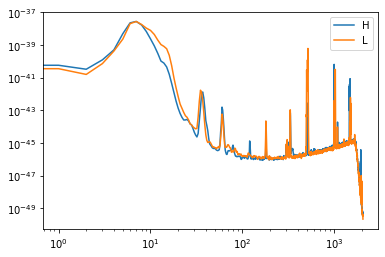

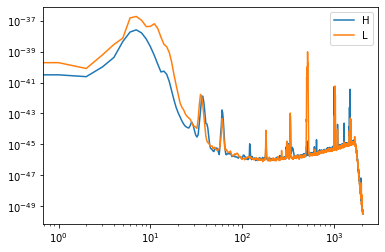

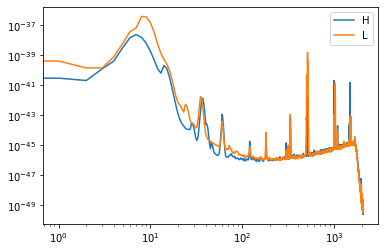

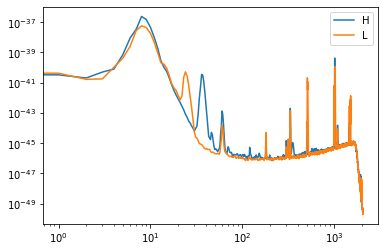

In [6]:
data = Noise()

## b.)

In [21]:
def white(event):
    Hnoise_spectrum_intp = interpolate.interp1d(event['H_freq'],event['H_noise'],kind='linear')
    Hspectr1 = np.fft.fft(event['H_strain'] * signal.get_window(window = 'tukey', Nx = len(event['H_strain'])))
    Hspectr2 = np.fft.fft(event['H_template'] * signal.get_window(window = 'tukey', Nx = len(event['H_template'])))
    
    Hfreq = np.fft.fftfreq(len(event['H_template']), event['H_dt'])
    
    Hspectr1 = Hspectr1/np.sqrt(Hnoise_spectrum_intp(np.abs(Hfreq)))
    Hspectr2 = Hspectr2/np.sqrt(Hnoise_spectrum_intp(np.abs(Hfreq)))
    Hwhite1 = np.fft.ifft(Hspectr1)
    Hwhite2 = np.fft.ifft(Hspectr2)
    
    Lnoise_spectrum_intp = interpolate.interp1d(event['L_freq'],event['L_noise'],kind='linear')
    Lspectr1 = np.fft.fft(event['L_strain'] * signal.get_window(window = 'tukey', Nx = len(event['L_strain'])))
    Lspectr2 = np.fft.fft(event['L_template'] * signal.get_window(window = 'tukey', Nx = len(event['L_template'])))
    
    Lfreq = np.fft.fftfreq(len(event['L_template']), event['L_dt'])
    
    Lspectr1 = Lspectr1/np.sqrt(Lnoise_spectrum_intp(np.abs(Lfreq)))
    Lspectr2 = Lspectr2/np.sqrt(Lnoise_spectrum_intp(np.abs(Lfreq)))
    Lwhite1 = np.fft.ifft(Lspectr1)
    Lwhite2 = np.fft.ifft(Lspectr2)
    
    return Hwhite1, Hwhite2 ,Lwhite1, Lwhite2, Hfreq, Lfreq
                                          
def match_filter(event):
    Hfs = 1/event['H_dt']
    Lfs = 1/event['L_dt']
    
    Hsignal_white, H_white_spect, Lsignal_white, L_white_spect, Hfreq, Lfreq = white(event)
    
    Hsignal_white = np.fft.fft(Hsignal_white) / Hfs
    H_white_spect = np.fft.fft(H_white_spect) / Hfs
    Lsignal_white = np.fft.fft(Lsignal_white) / Lfs
    L_white_spect = np.fft.fft(L_white_spect) / Lfs
    
    Hmf = Hsignal_white * H_white_spect.conjugate()
    Hmf = np.fft.ifft(Hmf)
    Lmf = Lsignal_white * L_white_spect.conjugate()
    Lmf = np.fft.ifft(Lmf)
    
    Ht = np.arange(len(event['H_strain']) * event['H_dt'], step = event['H_dt'])
    Lt = np.arange(len(event['L_strain']) * event['L_dt'], step = event['L_dt'])

    
    return Ht, Hmf, Lt, Lmf

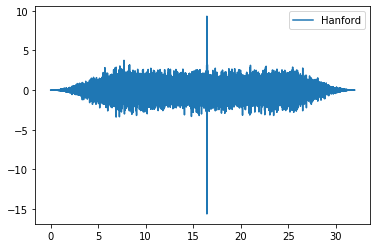

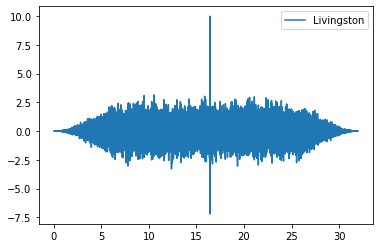

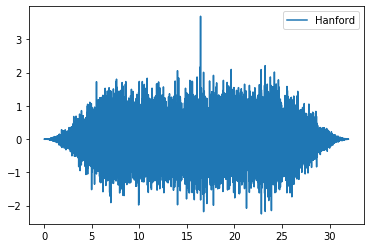

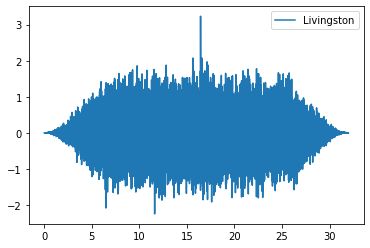

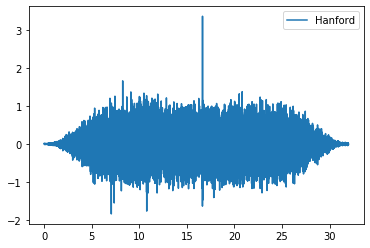

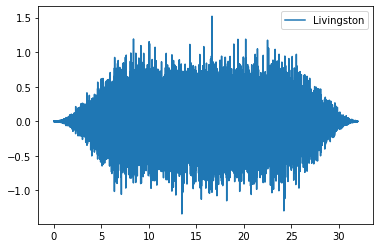

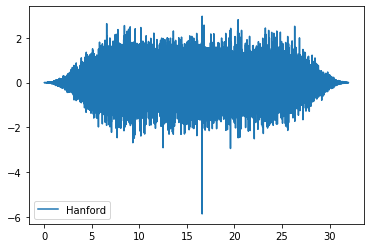

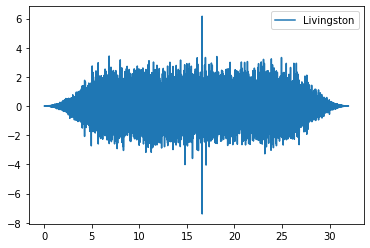

In [22]:
for i in range(len(list_events)):
    Ht, Hmf, Lt, Lmf = match_filter(data[i])
    Htshift = np.fft.fftshift(Ht)
    Ltshift = np.fft.fftshift(Lt)

    plt.plot(Htshift, np.real(Hmf), label = 'Hanford')
    plt.legend()
    plt.show()
    plt.plot(Ltshift, np.real(Lmf), label = 'Livingston')
    plt.legend()
    plt.show()

## c.)

In [23]:
for i in range(len(list_events)):
    Ht, Hmf, Lt, Lmf = match_filter(data[i])
    Hnoise = np.std(Hmf[5000:35000])
    HSNR = np.max(np.abs(Hmf))/Hnoise
    Lnoise = np.std(Lmf[5000:35000])
    LSNR = np.max(np.abs(Lmf))/Lnoise
    print('Estimated Hanford SNR = ', HSNR, 'and Estimated Livingston SNR =', LSNR)

Estimated Hanford SNR =  17.601027847292013 and Estimated Livingston SNR = 12.197033291640132
Estimated Hanford SNR =  6.532083837097693 and Estimated Livingston SNR = 5.955523998133934
Estimated Hanford SNR =  8.76587212784275 and Estimated Livingston SNR = 4.940284273524566
Estimated Hanford SNR =  8.388200547387106 and Estimated Livingston SNR = 7.851459098303718


## d.)

In [26]:
def SNR(event):
    Hfs = 1/event['H_dt']
    Lfs = 1/event['L_dt']
    Hsignal_white, H_white_spect, Lsignal_white, L_white_spect, Hfreq, Lfreq = white(event)
    
    Hsignal_white = np.fft.fft(Hsignal_white) / Hfs
    H_white_spect = np.fft.fft(H_white_spect) / Hfs
    Lsignal_white = np.fft.fft(Lsignal_white) / Lfs
    L_white_spect = np.fft.fft(L_white_spect) / Lfs
    
    Htest1 = np.fft.fft(event['H_strain']) / Hfs
    Htest2 = np.fft.fft(event['H_template']) / Hfs
    Ltest1 = np.fft.fft(event['L_strain']) / Lfs
    Ltest2 = np.fft.fft(event['L_template']) / Lfs
    
    Hdf = np.abs(Hfreq[1] - Hfreq[0])
    Ldf = np.abs(Lfreq[1] - Lfreq[0])

    Hnoise = np.interp(np.abs(Hfreq), Hfreq, Htest2)
    Lnoise = np.interp(np.abs(Lfreq), Lfreq, Ltest2)

    
    HSNR = Hsignal_white * H_white_spect.conjugate() / np.sqrt(Hnoise)
    LSNR = Lsignal_white * L_white_spect.conjugate() / np.sqrt(Lnoise)
    HSNR = 2*np.fft.ifft(HSNR)*Hfs
    LSNR = 2*np.fft.ifft(LSNR)*Lfs
    
    Hsigma = np.sqrt(np.abs(1*(H_white_spect * H_white_spect.conjugate() / Hnoise).sum() * Hdf))
    Lsigma = np.sqrt(np.abs(1*(L_white_spect * L_white_spect.conjugate() / Lnoise).sum() * Ldf))

    HnormSNR = HSNR/Hsigma
    LnormSNR = LSNR/Lsigma
    
    Hmax = round(len(event['H_strain']) / 2) 
    Lmax = round(len(event['L_strain']) / 2)
    HnormSNR = np.abs(np.roll(HnormSNR,Hmax))
    LnormSNR = np.abs(np.roll(LnormSNR,Lmax))
    
    return HnormSNR, LnormSNR


Hanford SNR =  17.79292647835989 and Livingston SNR = 12.690921138230303


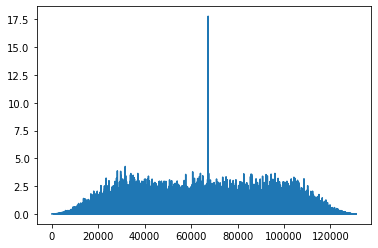

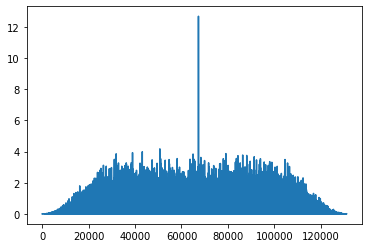

Hanford SNR =  6.720798113725238 and Livingston SNR = 6.055975871945419


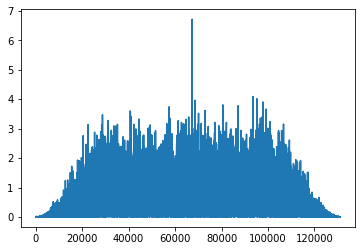

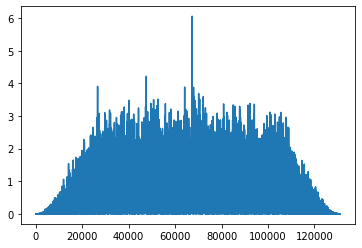

Hanford SNR =  8.887859538757487 and Livingston SNR = 5.245560301493724


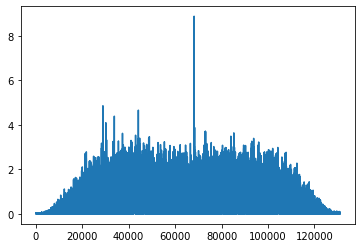

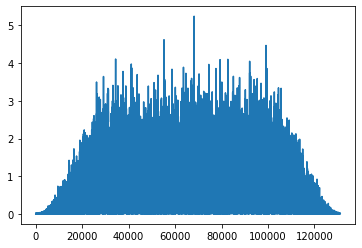

Hanford SNR =  8.35666887454496 and Livingston SNR = 7.98887621858497


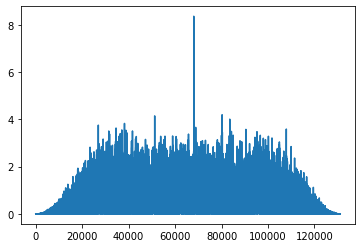

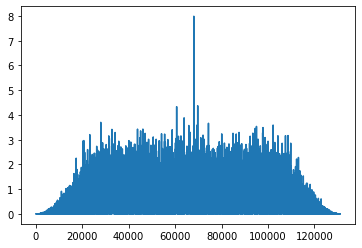

In [27]:
for i in range(len(list_events)):
    HSNR, LSNR = SNR(data[i])
    HSNRmax = HSNR[np.argmax(HSNR)]
    LSNRmax = LSNR[np.argmax(LSNR)]
    print('Hanford SNR = ', HSNRmax, 'and Livingston SNR =', LSNRmax)

    plt.plot(HSNR)
    plt.show()
    plt.plot(LSNR)
    plt.show()

## e.)